In [1]:
!pip install pennylane --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 28.2 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import math
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml


/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.4.33 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [3]:
import os
import random

def set_seed(seed):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [16]:
seed = 1234
set_seed(seed)

In [17]:
class CosineDataset(Dataset):
    def __init__(self, x_0, x_1, x_2, y):
        self.x_0 = x_0
        self.x_1 = x_1
        self.x_2 = x_2
        self.y = y

    def __len__(self):
        return len(self.x_0)

    def __getitem__(self, idx):
        return self.x_0[idx], self.x_1[idx], self.x_2[idx], self.y[idx]

In [18]:
class CosineDataGenerator:
    def __init__(self, num_samples=3000, n_ancilla=3, multiplicity=10, ratio=0.8):
        assert num_samples % 5 == 0, "num_samples must be a multiple of 5"
        self.num_samples = num_samples
        self.n_ancilla = n_ancilla
        self.multiplicity = multiplicity
        self.ratio = ratio
        self.delta = math.pi / (2 * 3 * num_samples)  # Step size

        # Precompute datasets
        self.train_data = self._generate_sequence('train')
        self.test_data = self._generate_sequence('test')

    def _generate_sequence(self, dataset_type):
        if dataset_type == 'train':
            start = 0
            end = self.ratio * (math.pi / 2) - 4 * self.delta
            steps = int(self.ratio * self.num_samples)
        else:
            start = self.ratio * (math.pi / 2)
            end = math.pi / 2 - 4 * self.delta
            steps = self.num_samples - int(self.ratio * self.num_samples)

        x0_data = torch.linspace(start, end, steps)
        x1_data = x0_data + 1 * self.delta
        x2_data = x0_data + 2 * self.delta
        x3_data = x0_data + 3 * self.delta

        input_seq_0 = torch.cos(self.multiplicity * x0_data.unsqueeze(-1))
        input_seq_1 = torch.cos(self.multiplicity * x1_data.unsqueeze(-1))
        input_seq_2 = torch.cos(self.multiplicity * x2_data.unsqueeze(-1))

        target_seq = torch.stack([
            torch.cos(self.multiplicity * (x0_data + i * self.delta)) for i in range(1, 4)
        ], dim=1)  # Shape: [steps, 3]

        return input_seq_0, input_seq_1, input_seq_2, target_seq

    def get_loaders(self, batch_size=32):
        train_dataset = CosineDataset(*self.train_data)
        test_dataset = CosineDataset(*self.test_data)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)

        return train_loader, test_loader

In [19]:
generator = CosineDataGenerator()
train_loader, test_loader = generator.get_loaders(batch_size=64)

In [20]:
class QSSMLayer(nn.Module):
    def __init__(self, n_ancilla=3, n_layers=6, backend="default.qubit"):
        super(QSSMLayer, self).__init__()

        self.n_ancilla = n_ancilla # number of ancilla qubits
        self.n_layers = n_layers # number of repeated blocks in U_B

        self.n_q1 = 1 + n_ancilla # 1 dimensional input + ancillae
        self.n_q2 = 2 * self.n_q1
        self.n_q3 = 3 * self.n_q1

        self.dev1 = qml.device(backend, wires=self.n_q1)
        self.dev2 = qml.device(backend, wires=self.n_q2)
        self.dev3 = qml.device(backend, wires=self.n_q3)

#step 1
        def circuit_1(inputs, r_z_1, r_x, r_z_2, c_r_z, U_B, U_A, r_y, c_r_y):

            qml.AngleEmbedding(inputs, wires=range(self.n_q1), rotation='Y') # angle embedding by rotation Y

            for l in range(self.n_layers):
                for i in range(self.n_q1):

                    qml.RX(r_z_1[l, i, :], wires=i)
                    qml.RZ(r_x[l, i, :], wires=i)
                    qml.RX(r_z_2[l, i, :], wires=i)

                    if i< self.n_q1 - 1:
                      qml.CRZ(c_r_z[l, i, :], wires = [i+1, i] )
                    if i == self.n_q1 - 1:
                      qml.CRZ(c_r_z[l, i, :], wires = [0, i])

            for i in range(self.n_q1):

                qml.RY(r_y[i], wires=i) # rotate Y every wrire

                if i < self.n_q1 - 1:
                  qml.CRY(c_r_y[i], wires=[i+1, i]) # chain of controlled Y gates

                if i == self.n_q1 - 1:
                  qml.CRY(c_r_y[i], wires=[0, i])

            #return [qml.expval(qml.PauliZ(i)) for i in range(self.n_q1)]
            return [qml.expval(qml.PauliZ(i)) for i in [1]]

#step 2
        def circuit_2(inputs, r_z_1, r_x, r_z_2, c_r_z, U_B, U_A, r_y, c_r_y):

            qml.AngleEmbedding(inputs, wires=range(self.n_q2), rotation='Y')

            for l in range(self.n_layers):
                for i in range(self.n_q1):

                    qml.RX(r_z_1[l, i, :], wires=i)
                    qml.RZ(r_x[l, i, :], wires=i)
                    qml.RX(r_z_2[l, i, :], wires=i)

                    if i< self.n_q1 - 1:
                      qml.CRZ(c_r_z[l, i, :], wires = [i+1, i] )
                    if i == self.n_q1 - 1:
                      qml.CRZ(c_r_z[l, i, :], wires = [0, i])

            for l in range(self.n_layers):
                for i in range(self.n_q1, self.n_q2):

                    qml.RX(r_z_1[l, i - self.n_q1, :], wires=i)
                    qml.RZ(r_x[l, i - self.n_q1, :], wires=i)
                    qml.RX(r_z_2[l, i - self.n_q1, :], wires=i)

                    if i< self.n_q2 - 1:
                      qml.CRZ(c_r_z[l, i - self.n_q1, :], wires = [i+1, i] )
                    if i == self.n_q2 - 1:
                      qml.CRZ(c_r_z[l, i - self.n_q1, :], wires = [self.n_q1, i])

            # Apply e^{1*U_A[i,j] Z_i Z_j} to qubits 0 1 2
            for i in range(self.n_q1):
              for j in range(i+1, self.n_q1):
                qml.IsingZZ(U_A[i,j], wires=[i, j])

            # RY and CRY
            # wires of x_0
            for i in range(self.n_q2):

                if i < self.n_q1:

                  qml.RY(r_y[i], wires=i) # rotate Y every wrire

                  qml.CRY(c_r_y[i], wires=[i+1, i]) # chain of controlled Y gates


            # wires of x_1
                if ( i in range(self.n_q1, self.n_q2) ):

                  qml.RY(r_y[i - self.n_q1], wires=i)

                  if i < self.n_q2 - 1:
                    qml.CRY(c_r_y[i - self.n_q1], wires=[i+1, i])

                  if i == self.n_q2 - 1:
                    qml.CRY(c_r_y[i - self.n_q1], wires=[0, i])

            #return [qml.expval(qml.PauliZ(i)) for i in range(self.n_q1)]
            return [qml.expval(qml.PauliZ(i)) for i in [1]]

# step 3
        def circuit_3(inputs, r_z_1, r_x, r_z_2, c_r_z, U_B, U_A, r_y, c_r_y):

            qml.AngleEmbedding(inputs, wires=range(self.n_q3), rotation='Y')

            for l in range(self.n_layers):
                for i in range(self.n_q1):

                    qml.RX(r_z_1[l, i, :], wires=i)
                    qml.RZ(r_x[l, i, :], wires=i)
                    qml.RX(r_z_2[l, i, :], wires=i)

                    if i< self.n_q1 - 1:
                      qml.CRZ(c_r_z[l, i, :], wires = [i+1, i] )
                    if i == self.n_q1 - 1:
                      qml.CRZ(c_r_z[l, i, :], wires = [0, i])


            for l in range(self.n_layers):
                for i in range(self.n_q1, self.n_q2):

                    qml.RX(r_z_1[l, i - self.n_q1, :], wires=i)
                    qml.RZ(r_x[l, i - self.n_q1, :], wires=i)
                    qml.RX(r_z_2[l, i - self.n_q1, :], wires=i)

                    if i< self.n_q2 - 1:
                      qml.CRZ(c_r_z[l, i - self.n_q1, :], wires = [i+1, i] )
                    if i == self.n_q2 - 1:
                      qml.CRZ(c_r_z[l, i - self.n_q1, :], wires = [self.n_q1, i])


            for l in range(self.n_layers):
                for i in range(self.n_q2, self.n_q3):
                    qml.RX(r_z_1[l, i - self.n_q2, :], wires=i)
                    qml.RZ(r_x[l, i - self.n_q2, :], wires=i)
                    qml.RX(r_z_2[l, i - self.n_q2, :], wires=i)

                    if i< self.n_q3 - 1:
                      qml.CRZ(c_r_z[l, i - self.n_q2, :], wires = [i+1, i] )
                    if i == self.n_q3 - 1:
                      qml.CRZ(c_r_z[l, i - self.n_q2, :], wires = [self.n_q2, i])


            # Apply e^{2*U_A[i,j] Z_i Z_j} to qubits 0 1 2
            for i in range(self.n_q1):
              for j in range(i+1, self.n_q1):
                qml.IsingZZ(2*U_A[i, j], wires=[i, j])


            # Apply e^{1*U_A[i,j] Z_i Z_j} to qubits 3 4 5
            for i in range(self.n_q1, self.n_q2):
              for j in range(i+1, self.n_q2):
                # Calculate relative indices for U_A
                i_rel = i - self.n_q1
                j_rel = j - self.n_q1
            # Check bounds before accessing U_A
                if i_rel < U_A.shape[0] and j_rel < U_A.shape[1]:
                  qml.IsingZZ(U_A[i_rel, j_rel], wires=[i, j])

            # RY and CRY
            # wires of x_0
            for i in range(self.n_q3):
                if i < self.n_q1:

                  qml.RY(r_y[i], wires=i) # rotate Y every wrire

                  qml.CRY(c_r_y[i], wires=[i+1, i]) # chain of controlled Y gates


            # wires of x_1
                if i in range(self.n_q1, self.n_q2):

                  qml.RY(r_y[i - self.n_q1], wires=i)

                  qml.CRY(c_r_y[i - self.n_q1], wires=[i+1, i]) # chain of controlled Y gates


            # wires of x_2
                if i in range(self.n_q2, self.n_q3):
                  qml.RY(r_y[i - self.n_q2], wires=i) # rotate Y every wrire

                  if i < self.n_q3 - 1:
                    qml.CRY(c_r_y[i - self.n_q2], wires=[i+1, i]) # chain of controlled Y gates

                  if i == self.n_q3 - 1:
                    qml.CRY(c_r_y[i - self.n_q2], wires=[0, i])


            #return [qml.expval(qml.PauliZ(i)) for i in range(self.n_q1)]
            return [qml.expval(qml.PauliZ(i)) for i in [1]]

        weight_shapes = {
            "r_z_1": (self.n_layers, self.n_q1, 1),
            "r_x": (self.n_layers, self.n_q1, 1),
            "r_z_2": (self.n_layers, self.n_q1, 1),
            "c_r_z": (self.n_layers, self.n_q1, 1),
            "U_B": (self.n_layers, 1, self.n_q1),
            "U_A":(self.n_q1, self.n_q1),
            "r_y": (self.n_q1, 1),
            "c_r_y": (self.n_q1, 1),
        }
        # Add initialization

        self.qlayer_1 = qml.qnn.TorchLayer(qml.QNode(circuit_1, self.dev1, interface="torch"), weight_shapes)
        self.qlayer_2 = qml.qnn.TorchLayer(qml.QNode(circuit_2, self.dev2, interface="torch"), weight_shapes)
        self.qlayer_3 = qml.qnn.TorchLayer(qml.QNode(circuit_3, self.dev3, interface="torch"), weight_shapes)

        # Uniform initialization of all parameters in each quantum layer
        init_left, init_right = -1.0, 1.0
        for layer in [self.qlayer_1, self.qlayer_2, self.qlayer_3]:
          for name, param in layer.named_parameters():
            torch.nn.init.uniform_(param, a=init_left, b=init_right)

    def forward(self, x_0, x_1, x_2):
        out_0 = torch.mean(self.qlayer_1(x_0), dim=1)  # shape: [batch_size]
        out_1 = torch.mean(self.qlayer_2(x_1), dim=1)
        out_2 = torch.mean(self.qlayer_3(x_2), dim=1)
        combined_out = torch.stack([out_0, out_1, out_2], dim=1)  # [batch_size, 3]
        return combined_out


In [21]:
model = QSSMLayer()

In [22]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=5*1e-2)

In [23]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_params(model))

432


In [24]:
# Test random function
model.eval()
test_loss_all = 0.0
test_loss_y2 = 0.0
num_batch = 0

with torch.no_grad():
    for batch_x_0, batch_x_1, batch_x_2, batch_y in test_loader:
        output = model(batch_x_0, batch_x_1, batch_x_2)

        loss_all = criterion(output, batch_y)
        test_loss_all += loss_all.item()

        loss_y2 = criterion(output[:, 2], batch_y[:, 2]) # test only given x0 x1 x2, predict x3
        test_loss_y2 += loss_y2.item()
        num_batch += 1

    test_loss_all /= num_batch
    test_loss_y2 /= num_batch
print(f"\n Test Loss before Training (all steps): {test_loss_all:.4f}")
print(f"\n Test Loss before Training (3rd step): {test_loss_y2:.4f}")



 Test Loss before Training (all steps): 0.8670

 Test Loss before Training (3rd step): 0.6753


In [25]:
loss_history = []

In [26]:
# Training
n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0
    num_batch = 0

    for batch_x_0, batch_x_1, batch_x_2, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_x_0, batch_x_1, batch_x_2)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        num_batch += 1
    epoch_loss /= num_batch
    #if epoch%10 == 0:
    loss_history.append(epoch_loss)
    print(f"Epoch {epoch+1}/{n_epochs} - Loss: {epoch_loss:.4f}")

Epoch 1/100 - Loss: 0.3985
Epoch 2/100 - Loss: 0.1665
Epoch 3/100 - Loss: 0.0838
Epoch 4/100 - Loss: 0.0484
Epoch 5/100 - Loss: 0.0330
Epoch 6/100 - Loss: 0.0252
Epoch 7/100 - Loss: 0.0208
Epoch 8/100 - Loss: 0.0180
Epoch 9/100 - Loss: 0.0162
Epoch 10/100 - Loss: 0.0148
Epoch 11/100 - Loss: 0.0138
Epoch 12/100 - Loss: 0.0130
Epoch 13/100 - Loss: 0.0124
Epoch 14/100 - Loss: 0.0119
Epoch 15/100 - Loss: 0.0115
Epoch 16/100 - Loss: 0.0111
Epoch 17/100 - Loss: 0.0109
Epoch 18/100 - Loss: 0.0106
Epoch 19/100 - Loss: 0.0104
Epoch 20/100 - Loss: 0.0103
Epoch 21/100 - Loss: 0.0101
Epoch 22/100 - Loss: 0.0100
Epoch 23/100 - Loss: 0.0099
Epoch 24/100 - Loss: 0.0098
Epoch 25/100 - Loss: 0.0096
Epoch 26/100 - Loss: 0.0096
Epoch 27/100 - Loss: 0.0095
Epoch 28/100 - Loss: 0.0095
Epoch 29/100 - Loss: 0.0094
Epoch 30/100 - Loss: 0.0093
Epoch 31/100 - Loss: 0.0093
Epoch 32/100 - Loss: 0.0092
Epoch 33/100 - Loss: 0.0091
Epoch 34/100 - Loss: 0.0092
Epoch 35/100 - Loss: 0.0091
Epoch 36/100 - Loss: 0.0091
E

In [27]:
#Evaluation
model.eval()
test_loss_all = 0.0
test_loss_y2 = 0.0
num_batch = 0
x_3_list = []
y_2_list = []

with torch.no_grad():
    for batch_x_0, batch_x_1, batch_x_2, batch_y in test_loader:
        output = model(batch_x_0, batch_x_1, batch_x_2)

        loss_all = criterion(output, batch_y)
        test_loss_all += loss_all.item()

        loss_y2 = criterion(output[:, 2], batch_y[:, 2])
        test_loss_y2 += loss_y2.item()

        x_3_list.append(output[:, 2].tolist())
        y_2_list.append(batch_y[:, 2].tolist())

        num_batch += 1
    test_loss_all /= num_batch
    test_loss_y2 /= num_batch
print(f"\n Final test Loss (all steps): {test_loss_all:.4f}")
print(f"\n Final test Loss (3rd step): {test_loss_y2:.4f}")


 Final test Loss (all steps): 0.0095

 Final test Loss (3rd step): 0.0098


In [28]:
#print(output.shape)
#print(output[:, 2])

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

In [30]:
n_steps = len(loss_history)

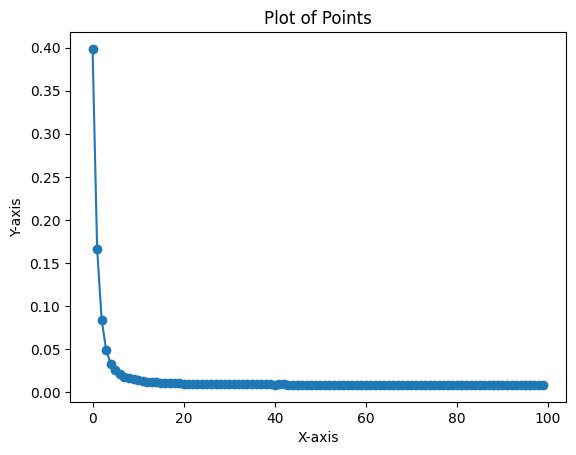

In [31]:

x_coords = [i for i in range(n_steps)]
y_coords = loss_history

plt.plot(x_coords, y_coords, c="#1f77b4", marker="o")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Plot of Points')
plt.show()

In [32]:
print(loss_history)

[0.39847090565844584, 0.1664889758746875, 0.083831167534778, 0.048421115957592666, 0.032964954936974926, 0.02522894171507735, 0.02083794145207656, 0.018019475557498242, 0.016248995928387893, 0.014813118957375226, 0.013761021564469525, 0.012974493573174664, 0.012392546099267508, 0.011910515972168037, 0.011477318739420489, 0.01114927300889241, 0.010904509243310281, 0.010616637950174902, 0.010425708403712824, 0.01030521969752092, 0.010078146318463902, 0.009994632564485073, 0.009909760464276923, 0.009751233541847844, 0.009622206886936175, 0.009605351087980364, 0.009517386053247671, 0.009468500649458483, 0.009365218201358067, 0.00932991706864222, 0.009286946077880106, 0.00922214754514004, 0.009147174350035033, 0.009195103935015044, 0.009117615102839313, 0.009106365044748313, 0.00908925501923812, 0.009068472519222843, 0.008973662373854926, 0.008956832798982137, 0.008910067403983129, 0.008950222675737581, 0.008954905132812104, 0.008889008950638143, 0.008863894158582153, 0.00886005986677973, 0

In [33]:
print(x_3_list)

[[0.8364229798316956, 0.836405873298645, 0.836374044418335, 0.8363275527954102, 0.8362663388252258, 0.8361904621124268, 0.8360999226570129, 0.8359946608543396, 0.835874617099762, 0.8357399106025696, 0.8355904221534729, 0.8354262113571167, 0.8352472186088562, 0.8350533246994019, 0.8348447680473328, 0.8346213102340698, 0.8343830108642578, 0.8341297507286072, 0.8338617086410522, 0.8335785865783691, 0.8332806825637817, 0.8329676389694214, 0.8326396346092224, 0.83229660987854, 0.8319384455680847, 0.831565260887146, 0.8311767578125, 0.8307731747627258, 0.8303542733192444, 0.8299201726913452, 0.829470694065094, 0.8290059566497803, 0.828525722026825, 0.8280301094055176, 0.8275189995765686, 0.8269922733306885, 0.8264499306678772, 0.8258921504020691, 0.8253185749053955, 0.8247291445732117, 0.8241240978240967, 0.8235029578208923, 0.8228662014007568, 0.8222132921218872, 0.8215444087982178, 0.820859432220459, 0.8201582431793213, 0.8194407820701599, 0.8187073469161987, 0.8179574608802795, 0.81719100

In [34]:
print(y_2_list)

[[0.9999862909317017, 0.9999452233314514, 0.9998767375946045, 0.9997808933258057, 0.9996576309204102, 0.9995070099830627, 0.9993290305137634, 0.9991236925125122, 0.9988909363746643, 0.998630940914154, 0.9983434677124023, 0.9980287551879883, 0.9976866841316223, 0.9973171949386597, 0.9969205856323242, 0.9964964985847473, 0.9960452318191528, 0.9955666065216064, 0.9950607419013977, 0.9945275783538818, 0.9939674139022827, 0.9933797717094421, 0.9927650690078735, 0.9921231269836426, 0.9914539456367493, 0.9907578229904175, 0.9900343418121338, 0.9892838597297668, 0.9885061979293823, 0.9877015352249146, 0.9868696928024292, 0.9860112071037292, 0.9851253032684326, 0.9842126369476318, 0.9832730293273926, 0.9823063015937805, 0.98131263256073, 0.9802924990653992, 0.9792453646659851, 0.978171169757843, 0.9770703911781311, 0.9759426712989807, 0.9747886061668396, 0.9736074805259705, 0.972399890422821, 0.971165657043457, 0.9699046015739441, 0.9686169624328613, 0.9673032760620117, 0.9659628868103027, 0.96

In [35]:
file_path = 'simple_model.pth'
torch.save(model.state_dict(), file_path)

In [38]:
model1 = QSSMLayer()
model1.load_state_dict(torch.load(file_path))
model1.eval()

<ipython-input-38-80a699686ac3>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load(file_path))


QSSMLayer(
  (qlayer_1): <Quantum Torch Layer: func=circuit_1>
  (qlayer_2): <Quantum Torch Layer: func=circuit_2>
  (qlayer_3): <Quantum Torch Layer: func=circuit_3>
)

In [41]:
#Evaluation
model1.eval()
test_loss_all = 0.0
test_loss_y2 = 0.0
num_batch = 0
output_list = []
y_list = []

with torch.no_grad():
    for batch_x_0, batch_x_1, batch_x_2, batch_y in test_loader:
        output = model1(batch_x_0, batch_x_1, batch_x_2)

        loss_all = criterion(output, batch_y)
        test_loss_all += loss_all.item()

        loss_y2 = criterion(output[:, 2], batch_y[:, 2])
        test_loss_y2 += loss_y2.item()

        output_list.append(output.tolist())
        y_list.append(batch_y.tolist())

        num_batch += 1
    test_loss_all /= num_batch
    test_loss_y2 /= num_batch
print(f"\n Final test Loss (all steps): {test_loss_all:.4f}")
print(f"\n Final test Loss (3rd step): {test_loss_y2:.4f}")


 Final test Loss (all steps): 0.0095

 Final test Loss (3rd step): 0.0098


In [42]:
print(output_list)

[[[0.8400757312774658, 0.8365865349769592, 0.8364229798316956], [0.8400683403015137, 0.8365743160247803, 0.836405873298645], [0.8400461673736572, 0.8365473747253418, 0.836374044418335], [0.8400092720985413, 0.8365057706832886, 0.8363275527954102], [0.8399574756622314, 0.8364495635032654, 0.8362663388252258], [0.8398910164833069, 0.8363785743713379, 0.8361904621124268], [0.8398096561431885, 0.8362929224967957, 0.8360999226570129], [0.8397135138511658, 0.8361926078796387, 0.8359946608543396], [0.8396025896072388, 0.8360775113105774, 0.835874617099762], [0.8394768238067627, 0.8359478116035461, 0.8357399106025696], [0.8393361568450928, 0.8358032703399658, 0.8355904221534729], [0.8391807079315186, 0.835644006729126, 0.8354262113571167], [0.8390103578567505, 0.8354699611663818, 0.8352472186088562], [0.8388251066207886, 0.8352811932563782, 0.8350533246994019], [0.8386250734329224, 0.8350775837898254, 0.8348447680473328], [0.8384100198745728, 0.8348590731620789, 0.8346213102340698], [0.8381800

In [43]:
print(y_list)

[[[0.9999985098838806, 0.9999939203262329, 0.9999862909317017], [0.9999756813049316, 0.9999619722366333, 0.9999452233314514], [0.999925434589386, 0.999902606010437, 0.9998767375946045], [0.9998478293418884, 0.9998158812522888, 0.9997808933258057], [0.999742865562439, 0.9997017979621887, 0.9996576309204102], [0.9996105432510376, 0.9995602965354919, 0.9995070099830627], [0.9994508028030396, 0.9993914365768433, 0.9993290305137634], [0.9992637038230896, 0.9991952180862427, 0.9991236925125122], [0.999049186706543, 0.9989715814590454, 0.9988909363746643], [0.998807430267334, 0.9987207055091858, 0.998630940914154], [0.9985381960868835, 0.9984423518180847, 0.9983434677124023], [0.9982417225837708, 0.9981367588043213, 0.9980287551879883], [0.997917890548706, 0.997803807258606, 0.9976866841316223], [0.9975666403770447, 0.997443437576294, 0.9973171949386597], [0.9971882104873657, 0.9970559477806091, 0.9969205856323242], [0.9967823624610901, 0.9966409802436829, 0.9964964985847473], [0.996349275112